### Introduction

The ozone nonattainment area (NAA) in Colorado is set under the 2008 National Ambient Air Quality Standards (NAAQS) and the 2015 NAAQS. Originally, these two standards had the same boundaries. In December 2021, the EPA added the Northern portion of Weld County to the 2015 NAAQS boundary, but left the 2008 NAAQS the same. So, we are creating a map that demonstrates the regions that the State Implementation Plan would address.   

In [1]:
import os
import geopandas as gpd
import plotly.graph_objects as go
import config # Imports config.py where keys are stored
import folium
from shapely.ops import cascaded_union

### Read in shapefiles for Colorado counties and the EPA designated NAA

In [2]:
regions2015 = gpd.read_file('./ozone_8hr_2015std_naa_shapefile/ozone_8hr_2015std_naa.shp')
weld_county = gpd.read_file('./weld_county_boundary/County_Boundary_open_data.shp')
colorado = gpd.read_file('./Colorado_County_Boundaries/Colorado_County_Boundaries.shp')
regions2008 = gpd.read_file('./ozone_8hr_2008std_naa_shapefile/ozone_8hr_2008std_naa.shp')

In [3]:
# Tidying up and creating a new county column
colorado.columns = colorado.columns.str.lower()
colorado.county = colorado.county.str.title()

In [4]:
naa_counties = ['Adams', 
                'Arapahoe',
                'Boulder',
                'Broomfield',
                'Denver',
                'Douglas',
                'Jefferson',
                'Larimer',
                'Weld',
                ]

In [5]:
# Filter for Denver/NFR region, 2015 NAAQS boundary
denver2015 = regions2015[regions2015['AREA_NAME'] == 'Denver Metro/North Front Range, CO'].reset_index(drop=True)
# Filter for Denver/NFR region, 2008 NAAQS boundary
denver2008 = regions2008[regions2008['AREA_NAME'].str.contains('Denver')].reset_index(drop=True)
# Filter for NAA counties in Colorado
naa_counties = colorado[colorado['county'].isin(naa_counties)]

### Visually inspect the polygons

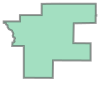

In [6]:
denver2015['geometry'][0]

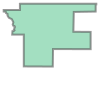

In [7]:
denver2008['geometry'][0]

In [8]:
# weld_county['geometry'][0]

In [9]:
# Save these shapefiles in case they are needed
denver2015.to_file('./ozone_8hr_2015std_naa_shapefile/denverNFR.shp')
denver2008.to_file('./ozone_8hr_2008std_naa_shapefile/denverNFR.shp')

### Create map with original NAA boundary

In [10]:
mapbox_access_token = config.mapbox_key

Make sure we are using the WGS84 reference system, coded as EPSG:4326

In [11]:
naa_counties_4326 = naa_counties.to_crs(epsg=4326)
denver2008_4326 = denver2008.to_crs(epsg=4326)
denver2015_4326 = denver2015.to_crs(epsg=4326)

To find the geometric properties (i.e. centroid), we need to calculate them while in a projected coordinate system, EPSG:2263, then convert back to our geographic system, EPSG:4326 for plotting.

In [12]:
# Find the centroid of the counties (for naming)
naa_counties_4326['centroid'] = naa_counties_4326.to_crs(epsg=2263) \
                                .centroid.to_crs(epsg=4326)                           
# Sort alphabetically
naa_counties_4326.sort_values('county', ascending=True, inplace=True)

# Get the centroid of the NAA, use to set location on map
denver2008_centroid = denver2008.to_crs(epsg=2263).centroid.to_crs(epsg=4326)

Combine Weld Co with the 2008 boundary to form the 2015 boundary.  
The 2015 boundaries were not yet published, and thus needed to be created.

In [13]:
# Combine polygons together
# https://stackoverflow.com/questions/40385782/make-a-union-of-polygons-in-geopandas-or-shapely-into-a-single-geometry
weld_county.crs = 'EPSG:4326'
polygons = [denver2008_4326['geometry'][0], weld_county['geometry'][0]]
new_boundary = gpd.GeoSeries(cascaded_union(polygons))
new_boundary.crs = 'EPSG:4326'

Using the combination 2008 boundary and Weld county, we plot the 2015 boundary in red.  
We also plot the 2008 boundary in orange, and county lines in dotted blue lines.  
Note the strange boundary lines that do not follow the county lines exactly on the east side of Weld Co, due to the EPA shapefiles are drawing the boundary this way.

In [15]:
# From example: https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html
m = folium.Map(location=[denver2008_centroid.y[0], denver2008_centroid.x[0]], 
               zoom_start=8, 
               tiles='openstreetmap')

# Draw NAA including Northern Weld
weld_sim_geo = new_boundary.simplify(tolerance=0.001)
weld_geo_j = weld_sim_geo.to_json()
weld_geo_j = folium.GeoJson(data=weld_geo_j,
                            style_function=lambda x: {'fillColor': 'red',
                                                      'fillOpacity': 0.4})
weld_geo_j.add_to(m)

# Draw NAA without Northern Weld
sim_geo = gpd.GeoSeries(denver2008_4326['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'yellow',
                                                 'fillOpacity': 0.2})
geo_j.add_to(m)

# Draw the boundaries of each county
county_text_position = [(15,0), # Adams
                        (15,10), # Arapahoe
                        (15,0), # Boulder
                        (15,0), # Broomfield
                        (45,0), # Denver
                        (25,0), # Douglas
                        (27,0), # Jefferson
                        (-15,0),  # Larimer
                        (15,50), # Weld
                       ]
for i in range(len(naa_counties_4326)):
    sim_geo = gpd.GeoSeries(naa_counties_4326.iloc[i]['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillOpacity': 0,
                                                     'weight': 2,
                                                     'dashArray': '10, 10',
                                                    },
                          )
    geo_j.add_to(m)
    # Add in the name of the county
    folium.map.Marker(
        [naa_counties_4326.iloc[i]['centroid'].y, naa_counties_4326.iloc[i]['centroid'].x],
        icon=folium.DivIcon(
            icon_size=(0, 0),
            icon_anchor=county_text_position[i],
            html='<div style="font-size: 12pt; font-weight: bold">%s' % naa_counties_4326.iloc[i]['county']
        )
    ).add_to(m)


deg = u'\N{DEGREE SIGN}'
    
notable_points = [[40.554833, -105.494444],
                  [40.713083, -105.494444],
                  [40.713083, -104.943602]]
points_formatted = [['105'+deg+'29\'40\"W', '40'+deg+'33\'17\"N'],
                    ['105'+deg+'29\'40\"W', '40'+deg+'42\'47\"N'],
                    ['104'+deg+'56\'37\"W', '40'+deg+'42\'47\"N']]

# points = [(-105.49364599966293, 40.55476800044306),
#           (-105.49398600005372, 40.71436500024487),
# #           (-105.49364599966293, 40.71443699996786), # Extra point in 2015 boundary
#           (-104.94346023378978, 40.71443699996786),]
# notable_points = [(y, x) for x, y in points]
# points_formatted = [['105'+deg+'29\'40\"W', '40'+deg+'33\'17.4\"N'],
#                     ['105'+deg+'29\'40\"W', '40'+deg+'42\'47.1\"N'],
#                     ['104'+deg+'56\'36.9\"W', '40'+deg+'42\'47.1\"N']]

for i in range(len(notable_points)):
    # Add in the lat, lon for certain points 
    folium.map.Marker(
        notable_points[i],
        icon=folium.DivIcon(
    #         icon_size=(250, 5),
            icon_anchor=(70, 32),
            html='<div style="font-size: 8pt">(%s, %s)' % (tuple(points_formatted[i]))
        )
    ).add_to(m)
    # Add in a red circle to denote the point
    folium.CircleMarker(location=notable_points[i],
                        fill_color='red',
                        radius=5,
                        weight=0,
                        fill_opacity=1).add_to(m)
m.save('./figures/naa_map_2.html')
m

Using the actual 2015 boundary from EPA. 
Basically identical to the previous combination of 2008 boundary and Weld Co.

In [17]:
# From example: https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html
m = folium.Map(location=[denver2008_centroid.y[0], denver2008_centroid.x[0]], 
               zoom_start=8, 
               tiles='openstreetmap')

# Draw NAA including Northern Weld
denver2015_sim_geo = denver2015_4326.simplify(tolerance=0.001)
denver2015_geo_j = denver2015_sim_geo.to_json()
denver2015_geo_j = folium.GeoJson(data=denver2015_geo_j,
                            style_function=lambda x: {'fillColor': 'red',
                                                      'fillOpacity': 0.4})
denver2015_geo_j.add_to(m)

# Draw NAA without Northern Weld
sim_geo = gpd.GeoSeries(denver2008_4326['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'yellow',
                                                 'fillOpacity': 0.2})
geo_j.add_to(m)

# Draw the boundaries of each county
county_text_position = [(15,0), # Adams
                        (15,10), # Arapahoe
                        (15,0), # Boulder
                        (15,0), # Broomfield
                        (45,0), # Denver
                        (25,0), # Douglas
                        (27,0), # Jefferson
                        (-15,0),  # Larimer
                        (15,50), # Weld
                       ]
for i in range(len(naa_counties_4326)):
    sim_geo = gpd.GeoSeries(naa_counties_4326.iloc[i]['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillOpacity': 0,
                                                     'weight': 2,
                                                     'dashArray': '10, 10',
                                                    },
                          )
    geo_j.add_to(m)
    # Add in the name of the county
    folium.map.Marker(
        [naa_counties_4326.iloc[i]['centroid'].y, naa_counties_4326.iloc[i]['centroid'].x],
        icon=folium.DivIcon(
            icon_size=(0, 0),
            icon_anchor=county_text_position[i],
            html='<div style="font-size: 12pt; font-weight: bold">%s' % naa_counties_4326.iloc[i]['county']
        )
    ).add_to(m)


deg = u'\N{DEGREE SIGN}'
    
notable_points = [[40.554833, -105.494444],
                  [40.713083, -105.494444],
                  [40.713083, -104.943602]]
points_formatted = [['105'+deg+'29\'40\"W', '40'+deg+'33\'17\"N'],
                    ['105'+deg+'29\'40\"W', '40'+deg+'42\'47\"N'],
                    ['104'+deg+'56\'37\"W', '40'+deg+'42\'47\"N']]

# points = [(-105.49364599966293, 40.55476800044306),
#           (-105.49398600005372, 40.71436500024487),
# #           (-105.49364599966293, 40.71443699996786), # Extra point in 2015 boundary
#           (-104.94346023378978, 40.71443699996786),]
# notable_points = [(y, x) for x, y in points]
# points_formatted = [['105'+deg+'29\'40\"W', '40'+deg+'33\'17.4\"N'],
#                     ['105'+deg+'29\'40\"W', '40'+deg+'42\'47.1\"N'],
#                     ['104'+deg+'56\'36.9\"W', '40'+deg+'42\'47.1\"N']]

for i in range(len(notable_points)):
    # Add in the lat, lon for certain points 
    folium.map.Marker(
        notable_points[i],
        icon=folium.DivIcon(
    #         icon_size=(250, 5),
            icon_anchor=(70, 32),
            html='<div style="font-size: 8pt">(%s, %s)' % (tuple(points_formatted[i]))
        )
    ).add_to(m)
    # Add in a red circle to denote the point
    folium.CircleMarker(location=notable_points[i],
                        fill_color='red',
                        radius=5,
                        weight=0,
                        fill_opacity=1).add_to(m)
# m.save('./figures/naa_map_2.html')
m